[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RelevanceAI/workflows/blob/main/workflows/vectorize/Vectorize_Your_Data_with_Relevance_AI.ipynb)

# Instructions

1. Paste the token copied to your clipboard provided from the 'Vectorize' Workflow dashboard.
2. Click the ▶️  on the left or go to "Runtime" -> "Run All" and click "Run anyway" on the warning that pops up.
3. You should see a progress bar underneath the form, keep this window opened and active until the progress bar is complete otherwise it'll terminate.

Note: 
- For fastest vectorization speed make sure to go to "Runtime" -> "Change runtime type" and enable "Hardware accelerator" as "GPU".


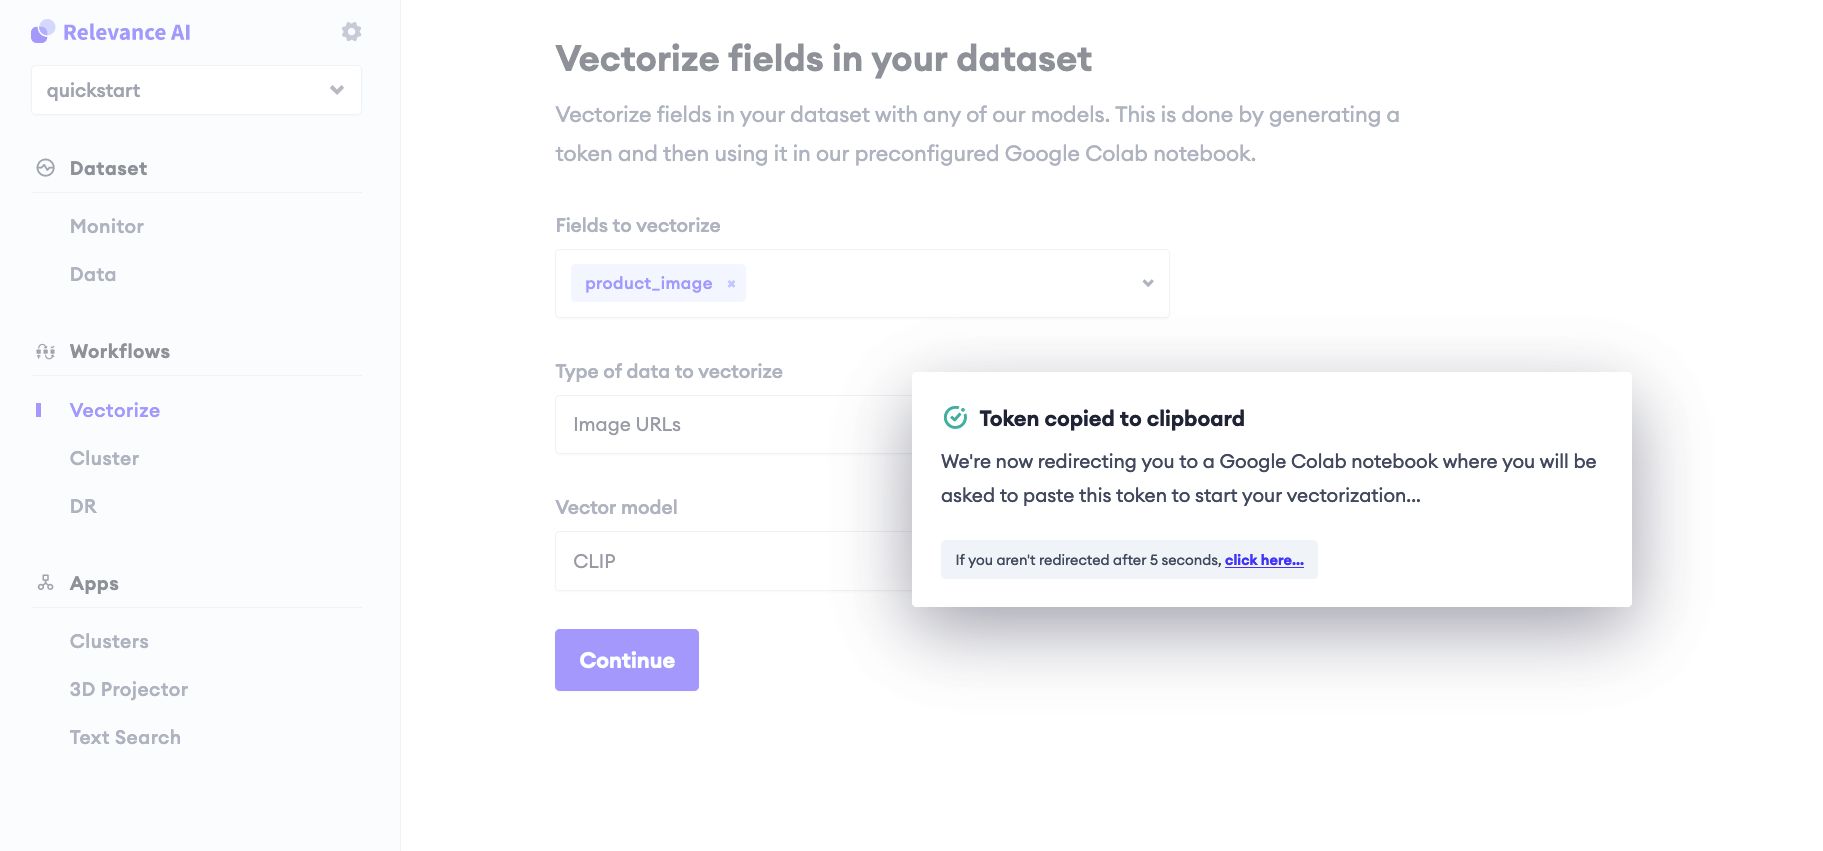

In [ ]:
#@title Paste token below and press ▶️  button to the left of this title { display-mode: "form" }
%tb

token = "" #@param {type:"string"}


show_warnings_in_logs = False #@param {type:"boolean"}
#@markdown Once the form is filled and you've clicked run, monitor below for logs of it running

import base64
import json
import warnings
warnings.filterwarnings('ignore')

config = json.loads(base64.b64decode(token + "==="))

import subprocess

def install_package(package):
    process = subprocess.Popen(['pip', 'install', package],
                        stdout=subprocess.PIPE, 
                        stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    return

!pip install -q RelevanceAI==2.1.6
print("Installing machine learning models and dependencies to vectorize data. Takes ~2mins.")

import contextlib

class DevNull:
    def write(self, msg):
        pass

from relevanceai import Client 
client = Client(token=config['authorizationToken'])

try:
    if config['model_id'] == 'clip' and config['encode_type'].lower() == 'image_urls':
        install_package("vectorhub[clip]")
        from vectorhub.bi_encoders.text_image.torch import Clip2Vec
        class Model(Clip2Vec):
            @property
            def __name__(self):
                return config['model_id']
        enc = Model()
        enc.encode = enc.encode_image

    elif config['model_id'] == 'clip' and config['encode_type'].lower() == 'text':
        install_package("vectorhub[clip]")
        from vectorhub.bi_encoders.text_image.torch import Clip2Vec
        class Model(Clip2Vec):
            @property
            def __name__(self):
                return config['model_id']
        enc = Model()
        enc.encode = enc.encode_text

    elif config['model_id'] == 'mpnet':
        install_package("vectorhub[encoders-text-sentence-transformers]")
        from vectorhub.encoders.text.sentence_transformers import SentenceTransformer2Vec
        class Model(SentenceTransformer2Vec):
            @property
            def __name__(self):
                return config['model_id']
        enc = Model("all-mpnet-base-v2")

    elif config['model_id'] == 'multiqampnet':
        install_package("vectorhub[encoders-text-sentence-transformers]")
        from vectorhub.encoders.text.sentence_transformers  import SentenceTransformer2Vec
        class Model(SentenceTransformer2Vec):
            @property
            def __name__(self):
                return config['model_id']
        enc = Model("multi-qa-mpnet-base-dot-v1")

    elif config['model_id'] == 'bit':
        install_package("vectorhub[encoders-image-tfhub]")
        from vectorhub.encoders.image.tfhub import BitMedium2Vec
        class Model(BitMedium2Vec):
            @property
            def __name__(self):
                return config['model_id']
        enc = Model()


except Exception as e:
    print(e)
    raise ValueError(f'Incorrect token provided. {json.dumps(config, indent=2)}')

print("Finished installing machine learning models and dependencies to vectorize data.")
# enc.__name__ = config['model_id']

import os
import sys
import warnings

f = open(os.devnull, 'w')
sys.stderr = f

def encode_documents(docs):
    try:
      if show_warnings_in_logs:
          with contextlib.redirect_stdout(None):
              with warnings.catch_warnings():
                  warnings.simplefilter("ignore")
                  return enc.encode_documents(config['fields'], docs)
      return enc.encode_documents(config['fields'], docs)
    except:
      raise Exception("===TRY RESTARTING COLAB NOTEBOOK! Click 'Runtime' > 'Restart runtime'===")

print("Starting to vectorize your data.")
# Simple bug fix lol
client.logger.warn = client.logger.warning
client.pull_update_push(config['dataset_id'], encode_documents, 
  show_progress_bar=True, 
  filters=[{'field' : f,
    'filter_type' : 'exists', 
    "condition":"==", 
    "condition_value":""} for f in config['fields']], 
    select_fields=config['fields'], retrieve_chunk_size=100)

print("Finished vectorizing your data with, you may close this window.")